**Baseline to Image Classification Using CNN (Dogs vs. Cats) with Tensorflow & Keras**

* Intro part.
* 2nd part: [Intro to CNN: Augmentation & Dropout](https://www.kaggle.com/imcr00z/intro-to-cnn-augmentation-dropout)
* 3rd part: [Transfer Learning (Dogs vs. Cats) 98% acc.](https://www.kaggle.com/imcr00z/transfer-learning-dogs-vs-cats-98-acc)

In [1]:
import shutil
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Unpack & load data
1. unpack data
1. split dogs and cats to train and valid datasets
1. put dogs and cats files according to their catalogs (need for ImageDataGenerator)

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
CONTENT_DIR = '/kaggle/content'

TRAIN_DIR = CONTENT_DIR + '/train'
TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR = CONTENT_DIR + '/valid'
VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

In [4]:
# Extract files
import zipfile
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zipf:
    zipf.extractall(CONTENT_DIR)
    
# !ls -la ../content/train/
# -rw-r--r-- 1 root root  12414 Nov  2 03:15 cat.0.jpg
# ...
# -rw-r--r-- 1 root root   3339 Nov  2 03:46 dog.9999.jpg

In [5]:
# Split cats and dogs images to train and valid datasets
img_filenames = os.listdir(TRAIN_DIR)
print('Num of images:', len(img_filenames))

dog_filenames = [fn for fn in img_filenames if fn.startswith('dog')]
cat_filenames = [fn for fn in img_filenames if fn.startswith('cat')]

dataset_filenames = train_test_split(
    dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
)

train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total
print('Train: {}, test: {}'.format(train_total, valid_total))

Num of images: 25000
Train: 22500, test: 2500


In [6]:
# Move images
make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(TRAIN_DIR, fn), dir)
    print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

100%|██████████| 11250/11250 [00:00<00:00, 17494.67it/s]


elements in /kaggle/content/train/dog: 11250


100%|██████████| 1250/1250 [00:00<00:00, 17560.32it/s]


elements in /kaggle/content/valid/dog: 1250


100%|██████████| 11250/11250 [00:00<00:00, 17730.13it/s]


elements in /kaggle/content/train/cat: 11250


100%|██████████| 1250/1250 [00:00<00:00, 18590.52it/s]

elements in /kaggle/content/valid/cat: 1250


In [7]:
# Uncomment and run to clear content dir
# !rm -rf ../content/*

# Preprocessing
1. decode images
1. rescale image layers from [0..255] to [0,1]

In [8]:
BATCH_SIZE = 128
IMAGE_SHAPE = 128

In [9]:
train_generator = ImageDataGenerator(rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255)

In [10]:
train_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Image visualization

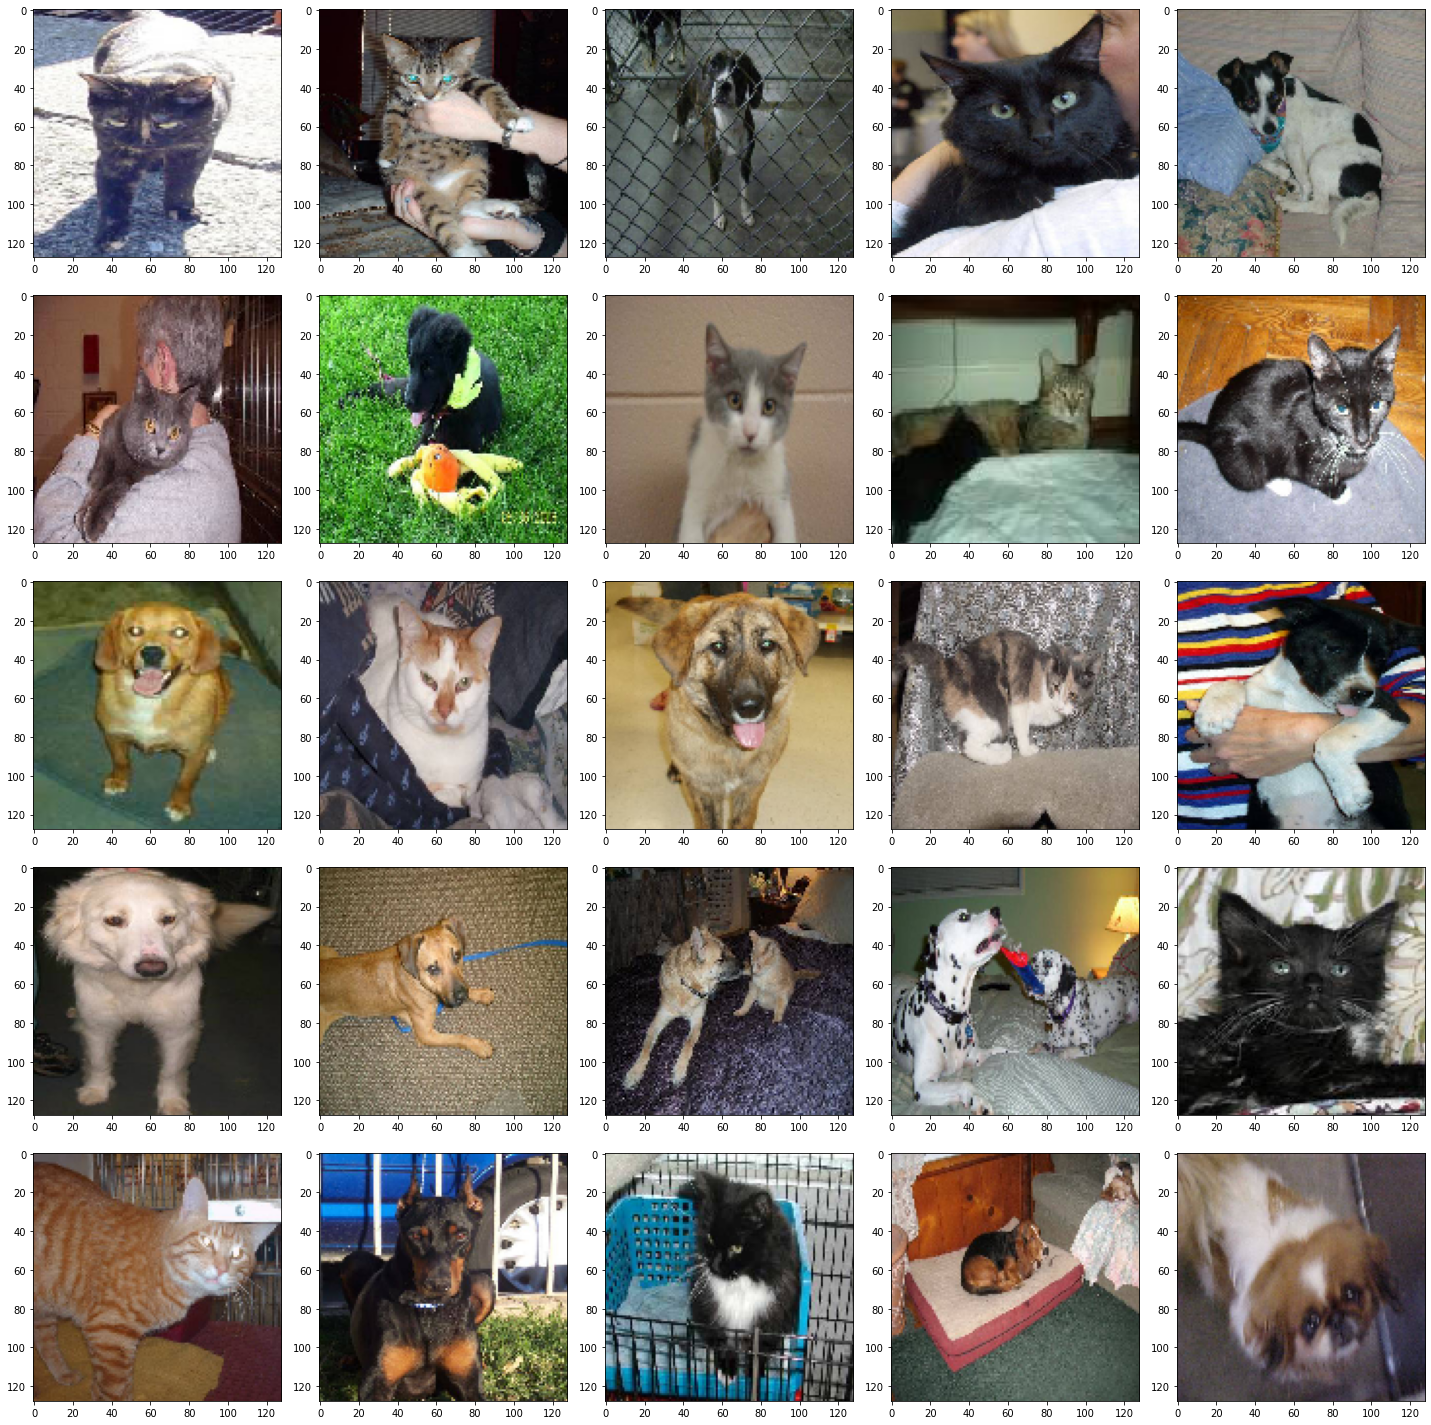

In [11]:
# show 25 images
some_pets = next(train_data)[0][:25]
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
for img, ax in zip(some_pets, axes.flatten()):
    ax.imshow(img)
plt.tight_layout()
plt.show()

# Model
1. create model
1. compile
1. summary
1. training

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
    ),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [15]:
EPOCHS = 60

In [16]:
history = model.fit_generator(
    generator=train_data,
    steps_per_epoch=(train_total + BATCH_SIZE - 1) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=(valid_total + BATCH_SIZE - 1) // BATCH_SIZE,
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-13 03:53:57.752482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60
176/176 [==============================] - 292s 2s/step - loss: 0.6274 - accuracy: 0.6304 - val_loss: 0.5778 - val_accuracy: 0.7148
Epoch 2/60
176/176 [==============================] - 283s 2s/step - loss: 0.5054 - accuracy: 0.7531 - val_loss: 0.4710 - val_accuracy: 0.7776
Epoch 3/60
176/176 [==============================] - 282s 2s/step - loss: 0.4241 - accuracy: 0.8070 - val_loss: 0.3807 - val_accuracy: 0.8284
Epoch 4/60
176/176 [==============================] - 282s 2s/step - loss: 0.3656 - accuracy: 0.8381 - val_loss: 0.4006 - val_accuracy: 0.8208
Epoch 5/60
176/176 [==============================] - 285s 2s/step - loss: 0.3205 - accuracy: 0.8578 - val_loss: 0.3504 - val_accuracy: 0.8496
Epoch 6/60
176/176 [==============================] - 285s 2s/step - loss: 0.2844 - accuracy: 0.8780 - val_loss: 0.3057 - val_accuracy: 0.8672
Epoch 7/60
176/176 [==============================] - 288s 2s/step - loss: 0.2457 - accuracy: 0.8977 - val_loss: 0.2895 - val_accuracy: 0.8716

In [17]:
# save model - optional
model.save('./checkpoints/model4_60epoch.h5')

In [18]:
# download model - optional
# import os
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink
# FileLink(r'./checkpoints/model4_60epoch.h5')

In [19]:
# set finish path
# os.chdir(r'..')

# Train visualization
Look to validation loss. You see overfitting after ? epoch. Maybe better stay there

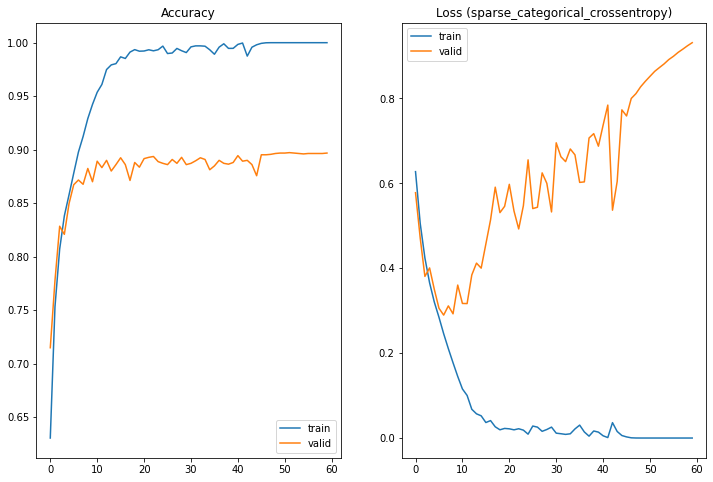

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='train')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='valid')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='train')
plt.plot(range(EPOCHS), history.history['val_loss'], label='valid')
plt.legend(loc='upper left')
plt.title('Loss (sparse_categorical_crossentropy)')

plt.show()

# Predictions
1. unzip test data
1. scale and predict
1. save results

In [21]:
TEST_DIR = CONTENT_DIR + '/test'

# Extract files
import zipfile
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zipf:
    zipf.extractall(TEST_DIR)

In [22]:
test_generator = ImageDataGenerator(rescale=1./255)

test_data = test_generator.flow_from_directory(
    directory=TEST_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)
test_data.reset()

test_total = len(test_data.filenames)
predict = model.predict_generator(test_data, steps=test_total, verbose=1)

Found 12500 images belonging to 1 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


12500/12500 [==============================] - 125s 10ms/step


In [23]:
# labels = dict((v,k) for k,v in train_data.class_indices.items())
# predictions = [labels[k] for k in np.argmax(predict,axis=1)]
# predictions

In [24]:
submission = pd.read_csv('/kaggle/input/dogs-vs-cats/sampleSubmission.csv', index_col='id')
submission['label'] = np.argmax(predict,axis=1)
submission.to_csv('./my_submission.csv')